In [1]:
import numpy as np
import pandas as pd

In [2]:
data_path = "data/Sample/train_df.csv"
test_data_path = "data/Sample/test_df.csv"

embeding_path = "data/BioWordVec_PubMed_MIMICIII_d200.vec.bin"
emb_dim = 200
sample_size = 3000
perc_train = 0.9

## process data

In [3]:
df = pd.read_csv(data_path, encoding = "latin", header = None)
df.drop(labels = [0], axis = "columns", inplace = True)
df.columns = ["clinical_note","Label"]
df = df.sample(n = sample_size, random_state = 31,replace=False)

In [4]:
from unidecode import unidecode
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

remove = ["xxxx xxxx","xxxx"]
def preprocess(text):
    text = text.lower()
    text = re.sub("@\S+|http\S+|#\S+", "", text)
    text = unidecode(text)
    # Tokenize
    tokenized_text = word_tokenize(text)
    cleaned_tokens = [t for t in tokenized_text if t.isalnum() and t not in remove]
    cleaned_string = " ".join(cleaned_tokens)
    return cleaned_string

df["clinical_note"] = df["clinical_note"].apply(lambda x : preprocess(x))

## determine the length of the cllinical note:

In [5]:
lengths = df["clinical_note"].apply(lambda x : len(x.split(" ")))
max_length = int(lengths.mean()+3*lengths.std())

## split dataset

In [6]:
from sklearn.model_selection import train_test_split as tts
df_train, df_val = tts(df, train_size = perc_train, shuffle = True, random_state = 42)

In [7]:
from keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(df_train["clinical_note"])
word_index = token.word_index
num_vocab = len(token.word_index) + 1 

Using Theano backend.


In [8]:
from keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(token.texts_to_sequences(df_train["clinical_note"]), maxlen = max_length, padding = "post")
x_val   = pad_sequences(token.texts_to_sequences(df_val["clinical_note"]), maxlen = max_length, padding = "post")
y_train = df_train["Label"].to_numpy(dtype = float).reshape(-1, 1)
y_val   = df_val["Label"].to_numpy(dtype = float).reshape(-1, 1)

## map embeddings

In [9]:
import torch
from gensim.models import KeyedVectors

In [10]:
device = "cpu"
word2vec = KeyedVectors.load_word2vec_format(embeding_path, binary=True)
embedding_matrix = np.zeros((num_vocab, emb_dim))
for word, i in word_index.items():
    try:
        embedding_vector=word2vec[word]
        embedding_matrix[i] = embedding_vector
    except:
        embedding_matrix[i] = np.random.normal(0, 1, (emb_dim,))

embeddings_tensor = torch.FloatTensor(embedding_matrix).to(device)

In [11]:
from torch.utils.data import DataLoader, TensorDataset

data_train = TensorDataset(torch.from_numpy(x_train).long(), torch.from_numpy(y_train).long())
data_val = TensorDataset(torch.from_numpy(x_val).long(), torch.from_numpy(y_val).long())
loader_train = DataLoader(data_train, shuffle = False, batch_size = 128)
loader_val = DataLoader(data_val, shuffle = False, batch_size = 128)

### model setup

In [12]:
import torch.nn.functional as F

def calc_accuracy(yhat, y):
    preds = torch.sigmoid(yhat)
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [13]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() 
    
    for text, labels in iterator:
        
        optimizer.zero_grad() 
        
        yhat = model(text)
        labels = labels.type_as(yhat)
        
        loss = criterion(yhat, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        accucracy = calc_accuracy(yhat, labels)
        epoch_acc += accucracy.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [21]:
from sklearn.metrics import precision_recall_fscore_support

def evalu(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad(): 
    
        for text, labels in iterator:
            
            yhat = model(text)
            labels = labels.type_as(yhat)
            
            loss = criterion(yhat, labels)
            epoch_loss += loss.item()
            
            accucracy = calc_accuracy(yhat, labels)
            epoch_acc += accucracy.item()
                    
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [22]:
import torch.nn as nn

class Model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout = 0.3):
        
        super().__init__()
        # Add embedding
        self.embedding = nn.Embedding.from_pretrained(embeddings_tensor, freeze = True)
        # BiLSTM Model
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers = 1,
            bidirectional = True, 
            batch_first = True
        )
        # add multi head attention:
        self.mha = nn.MultiheadAttention(2*hidden_dim, num_heads = 8)
        self.flatten = nn.Flatten() 
        self.fc1 = nn.Linear(max_length*2*hidden_dim, 512) 
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(dropout)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)  
        # LSTM output
        lstm_output, (ht, cell) = self.lstm(embedded) 
        # try if attention layer makes sense:
#         attn_output, attn_output_weights = self.mha(lstm_output, lstm_output, lstm_output)
        attn_output = lstm_output
        x = self.flatten(attn_output)
        # Classifer:
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = self.fc4(x)
        
        return output 

In [23]:
n_epochs = 5
output_dim = 1
hidden_dim = 64
model = Model(num_vocab, emb_dim, hidden_dim, output_dim)
print(model)

Model(
  (embedding): Embedding(1911, 200)
  (lstm): LSTM(200, 64, batch_first=True, bidirectional=True)
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12288, out_features=512, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [24]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [25]:
best_loss = float("inf")

output = {"train_loss" : [],"valid_loss" : [],  "train_acc" : [], "valid_acc" : []}

for epoch in range(n_epochs):

    start_time = time.time()
    
    train_loss, train_acc = train(model, loader_train, optimizer, criterion)
    valid_loss, valid_acc = evalu(model, loader_val, criterion)
    
    end_time = time.time()
    
    output["train_loss"].append(train_loss)
    output["valid_loss"].append(valid_loss)
    output["train_acc"].append(train_acc)
    output["valid_acc"].append(valid_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), f"model_{epoch+1}.pt")

    # show elaspsed time
    print(f"Epoch: {epoch} | Elapsed Time: {epoch_mins}m {epoch_secs}s")

Epoch: 0 | Elapsed Time: 0m 11s
Epoch: 1 | Elapsed Time: 0m 10s
Epoch: 2 | Elapsed Time: 0m 6s
Epoch: 3 | Elapsed Time: 0m 5s
Epoch: 4 | Elapsed Time: 0m 5s


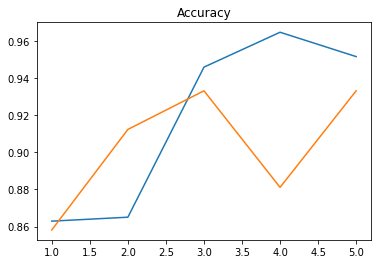

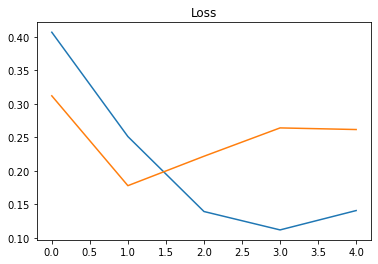

In [26]:
from matplotlib import pyplot as plt

t_acc = output["train_acc"]
t_loss = output["train_loss"]
v_acc = output["valid_acc"]
v_loss = output["valid_loss"]

epochs = range(1, n_epochs + 1)

plt.plot(epochs, t_acc)
plt.plot(epochs, v_acc)
plt.title("Accuracy")

plt.figure()
plt.plot(t_loss)
plt.plot(v_loss)
plt.title("Loss")

plt.show()

In [27]:
output = pd.DataFrame(output)
output

,train_loss,valid_loss,train_acc,valid_acc
0,0.407006,0.312081,0.862926,0.858191
1,0.251278,0.177911,0.865057,0.912405
2,0.139332,0.221842,0.946023,0.933239
3,0.111851,0.264165,0.964844,0.881155
4,0.140766,0.261747,0.951705,0.933239


In [28]:
df_test = pd.read_csv(data_path, encoding = "latin", header = None)
df_test.drop(labels = [0], axis = "columns", inplace = True)
df_test.columns = ["clinical_note","Label"]
df_test = df_test.sample(n = 786, random_state = 31,replace=False)
df_test["clinical_note"] = df_test["clinical_note"].apply(lambda x : preprocess(x))

x_test = pad_sequences(token.texts_to_sequences(df_test["clinical_note"]), maxlen = max_length, padding = "post")
y_test   = df_test["Label"].to_numpy(dtype = float).reshape(-1, 1)

data_test = TensorDataset(torch.from_numpy(x_test).long(), torch.from_numpy(y_test).long())
test_val = DataLoader(data_test, shuffle = False, batch_size = 128)
valid_loss, valid_acc = evalu(model, test_val, criterion)

In [29]:
valid_loss,valid_acc

(0.2338803213621889, 0.9362599168504987)